In [ ]:
import os
import torch.optim as optim
from torch import nn
import torch
import torchvision
import torchvision.transforms as transforms
import math
from PIL import Image
from torchvision.datasets import CIFAR100
import matplotlib.pyplot as plt
import numpy as np
import pickle
from torchsummary import summary
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#All the parameters
epoch = 100
epoch_consolidation = 50
epoch_fine_tune = 15
lr_finetune = 0.001
weight_decay = 0.0001
momentum = 0.9
gamma = 0.1
resnet_type = 5
batch_size = 128
K = 2000
SAVE_DIR = '/content/drive/MyDrive/model'
device = torch.device('cuda')
PATH = os.path.join(SAVE_DIR, "runtime_networks/dmc_net_" + str(classes_batch_size) + ".pth")
#Configuration specific parameters
#You can copy the proper parameters from configuration_setup.txt
classes_batch_size = 20
lr = 0.1
lr_cons = 0.01
F = classes_batch_size

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, channel_num, stride, downsample_layer = None):
    super(ResidualBlock, self).__init__()

    self.downsample = downsample_layer
    
    self.conv1 = nn.Sequential(
        nn.Conv2d(int(channel_num/stride), channel_num, 3, stride, padding=1),
        nn.BatchNorm2d(channel_num),
        nn.ReLU(),
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(channel_num, channel_num, 3, int(stride/stride), padding=1),
        nn.BatchNorm2d(channel_num),
    )
    self.relu = nn.ReLU() #Definiramo izvan bloka zbog skip connectiona

  def forward(self, x):
    skip_connection = x
    x = self.conv1(x)
    x = self.conv2(x)
    if(skip_connection.shape != x.shape):
      skip_connection = self.downsample(skip_connection)
    x = skip_connection + x
    x = self.relu(x)
    return x

In [ ]:
class ResidualNetwork(nn.Module):
  def __init__(self, out_channel=100, channel_num=16):
    super(ResidualNetwork, self).__init__()

    self.conv1 = nn.Sequential(
      nn.Conv2d(3, channel_num, 3, padding=1),
      nn.BatchNorm2d(channel_num),
      nn.ReLU(),
    )

    res_blocks = []

    for i in range(3 * resnet_type):
      if(i != 0 and i % resnet_type == 0):
        channel_num = channel_num*2
        res_blocks.append(ResidualBlock(channel_num, 2, nn.Sequential(
            nn.Conv2d(int(channel_num/2), channel_num, 1, 2),
            nn.BatchNorm2d(channel_num),
        )))
      else:
        res_blocks.append(ResidualBlock(channel_num, 1))

    self.residualblocks = nn.Sequential(*res_blocks)

    self.pool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(64, out_channel, bias=True)

  def forward(self, x):
    x = self.conv1(x)
    x = self.residualblocks(x)
    x = self.pool(x)
    x = x.reshape(x.shape[0], -1)
    out = self.fc(x)

    return out

In [ ]:
def runtime_evaluate(net, dataloader, iter, new=False):
    """
    Performs the runtime evaluation of the current performance of a
    given convolutional network. It can perform the evaluation on 
    both training and testing sets. Standard evaluation metrics are
    calcualted such as, accuracy and loss.
    Parameters
    ----------
    net: ConvolutionalModel
        ConvNet whose performance needs to be evaluated.
    type: bool
        True if eval is made on testing set, false otherwise
    save_path: str
        Path to the file where data should be saved.
    Return
    ------
    loss
        Current loss on the chosen set
    accuracy
        Current acc on the chosen set
    """
    net.eval()
    total = 0
    correct = 0
    lossFunc = nn.CrossEntropyLoss()
    accLoss = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            if new:
              for j, elem in enumerate(labels):
                labels[j] = elem - (classes_batch_size * iter)
            images = images.to(device=device)
            labels = labels.to(device=device)

            output = net.forward(images)
            loss = lossFunc(output, labels)
            _, predictions = torch.max(output.data, 1)
            total += labels.size(0)
            accLoss += loss.item()
            correct += (predictions == labels).sum().item()

    print("Accuracy of the neural network on CIFAR_100 is: %.2f %%" %((correct/total)*100))

    return (accLoss/(total/batch_size)), (correct/total)

In [ ]:
def plot_training_progress(save_dir, data):
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,8))

  linewidth = 2
  legend_size = 10
  train_color = 'r'
  val_color = 'g'
  
  num_points = len(data['train_loss'])
  x_data = np.linspace(1, num_points, num_points)
  ax1.set_title('Cross-entropy loss')
  ax1.plot(x_data, data['train_loss'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='train')
  ax1.plot(x_data, data['valid_loss'], marker='o', color=val_color,
           linewidth=linewidth, linestyle='-', label='validation')
  ax1.legend(loc='upper right', fontsize=legend_size)
  ax2.set_title('Average class accuracy')
  ax2.plot(x_data, data['train_acc'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='train')
  ax2.plot(x_data, data['valid_acc'], marker='o', color=val_color,
           linewidth=linewidth, linestyle='-', label='validation')
  ax2.legend(loc='upper left', fontsize=legend_size)
  ax3.set_title('Learning rate')
  ax3.plot(x_data, data['lr'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='learning_rate')
  ax3.legend(loc='upper left', fontsize=legend_size)

  print('Plotting in: ', save_dir)
  plt.savefig(save_dir)

In [ ]:
def final_evaluate(net, dataloader, iter, save_path, curr_classes):
    """
    Performs the final evaluation of the current performance of a
    given convolutional network. It performs evaluation on testing sets. 
    Standard evaluation metrics are calcualted such as, 
    accuracy and confusion matrix.
    Parameters
    ----------
    net: ConvolutionalModel
        ConvNet whose performance needs to be evaluated.
    save_path: str
        Path to the file where data should be saved.
    Return
    ------
    loss
        Current loss on the chosen set
    accuracy
        Current acc on the chosen set
    """
    net.eval()
    total = 0
    correct = 0
    confMatrix = np.zeros((len(curr_classes), len(curr_classes)), int)
    lossFunc = nn.CrossEntropyLoss()
    accLoss = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            if len(curr_classes) == classes_batch_size:
              for j, elem in enumerate(labels):
                labels[j] = elem - (classes_batch_size * iter)
            images = images.to(device=device)
            labels = labels.to(device=device)

            output = net.forward(images)
            loss = lossFunc(output, labels)
            _, predictions = torch.max(output.data, 1)
            total += labels.size(0)
            accLoss += loss.item()
            correct += (predictions == labels).sum().item()
            for j in range(labels.size(0)):
                confMatrix[predictions[j], labels[j]] += 1

    print("Accuracy of the neural network on CIFAR_100 is: %.2f %%" %((correct/total)*100))
    with open(save_path, "a+") as f:
      f.write(str(((correct/total)*100)) + '\n')
      prec, recall = specificMetrics(confMatrix)
      np.savetxt(f, prec, fmt='%.2f')
      np.savetxt(f, recall, fmt='%.2f')

    new_conf = pd.DataFrame(confMatrix)
    new_conf.columns = curr_classes
    new_conf.to_csv(save_path[:-3] + "csv")
    return (accLoss/(total/batch_size)), (correct/total)

def specificMetrics(confMatrix):
    """
    Calculates precision and recall from a given confusion
    matrix and returns calculated metrics.
    Parameters
    ----------
    confMatrix: n x n numpy array
        Made from the predictions and true labels of a
        given set of data
    Return
    ------
    precc
        Precision on all classes
    recal 
        Recall on all classes
    """
    precc = np.zeros(np.size(confMatrix, 0))
    recal = np.zeros(np.size(confMatrix, 0))
    for i in range(np.size(confMatrix, 0)):
        tp = 0
        fp = 0
        fn = 0
        for j in range(np.size(confMatrix, 0)):
            if i == j:
                tp += confMatrix[i, j]
            else:
                fn += confMatrix[j, i]
                fp += confMatrix[i, j]
            
        precc[i] += tp/(tp + fp)
        recal[i] += tp/(tp + fn)

    return precc, recal

In [ ]:
def changeTargets(targets_copy, targets, indices, classes):
  for i, elem in enumerate(targets_copy):
    targets[i] = indices.index(elem)
  new_classes = [classes[x] for x in indices]
  return new_classes

In [ ]:
trainTransform = transforms.Compose([
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))])

testTransform = transforms.Compose([    
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))])


trainSet = torchvision.datasets.CIFAR100(root=os.path.join(SAVE_DIR, 'data'), train=True,
                    download=False, transform=trainTransform)
testSet = torchvision.datasets.CIFAR100(root=os.path.join(SAVE_DIR, 'data'), train=False,
                    download=False, transform=testTransform)

classes=pickle.load(open(os.path.join(SAVE_DIR, 'data/cifar-100-python/meta'), 'rb'))
classes=classes['fine_label_names']
indices = []

with open(os.path.join(SAVE_DIR, 'data_prep/indices.txt'), "rb") as f:
    indices = pickle.load(f)

temp_targets = trainSet.targets.copy()
temp_testtargets = testSet.targets.copy()

classes = changeTargets(temp_targets, trainSet.targets, indices, classes)
_ = changeTargets(temp_testtargets, testSet.targets, indices, classes)
indices = list(range(0, len(classes)))
trainSet.classes = classes
testSet.classes = classes


trainLoaders = []
testLoaders = []
subsetsTrain = []
subsetsTest = []
for i in range(0, int(len(indices)/classes_batch_size)):
  indexTrain = [j for j, x in enumerate(trainSet.targets) if x in indices[classes_batch_size * i: classes_batch_size * (i + 1)]]
  indexTest = [j for j, x in enumerate(testSet.targets) if x in indices[classes_batch_size * i: classes_batch_size * (i + 1)]]
  subsetsTrain.append(torch.utils.data.Subset(trainSet, indexTrain))
  subsetsTest.append(torch.utils.data.Subset(testSet, indexTest))
  trainLoaders.append(torch.utils.data.DataLoader(subsetsTrain[i], batch_size=batch_size,
                                          shuffle=True, num_workers=0))
  testLoaders.append(torch.utils.data.DataLoader(subsetsTest[i], batch_size=batch_size,
                                          shuffle=True, num_workers=0))
  
  

In [ ]:
def sampleExemplars(iter):
    if iter == 1:
        indexDict = {}
        classLabels = np.zeros(100)
        counter = 0
        while counter < K :
            i = np.random.randint(0, 50000)
            if i in indexDict.keys():
              continue
            target = trainSet.targets[i]
            if target in indices[0: classes_batch_size * (iter + 1)] and classLabels[target] < int(K/(classes_batch_size * (iter + 1))):
                classLabels[target] += 1
                counter += 1
                indexDict[i] = target
        exemplars = torch.utils.data.Subset(trainSet, list(indexDict.keys()))
        exemplarsLoader = torch.utils.data.DataLoader(exemplars, batch_size=exemplars.__len__(),
                                                shuffle=True, num_workers=0)
        with open(os.path.join(SAVE_DIR, 'runtime_networks/exemplars.txt'), 'wb') as f: 
            pickle.dump(indexDict, f)
    else:
        with open(os.path.join(SAVE_DIR, 'runtime_networks/exemplars.txt'), 'rb') as f: 
            indexDict = pickle.load(f)
        keys_new = list(indexDict.keys())
        np.random.shuffle(keys_new)
        remove_counter = np.zeros(classes_batch_size*iter)
        number_exemp = int(K/(classes_batch_size  * (iter + 1)))
        counter = 0
        for i, elem in enumerate(keys_new):
            if remove_counter[indexDict[elem]] == number_exemp:
                indexDict.pop(elem)
            else:
                remove_counter[indexDict[elem]] += 1

        classLabels = np.zeros(100)
        counter = 0
        while counter < number_exemp * classes_batch_size:
            i = np.random.randint(0, 50000)
            if i in indexDict.keys():
              continue
            target = trainSet.targets[i]
            if target in indices[classes_batch_size * iter: classes_batch_size * (iter + 1)] and classLabels[target] < int(K/(classes_batch_size * (iter + 1))):
                classLabels[target] += 1
                counter += 1
                indexDict[i] = target

        exemplars = torch.utils.data.Subset(trainSet, list(indexDict.keys()))
        exemplarsLoader = torch.utils.data.DataLoader(exemplars, batch_size=exemplars.__len__(),
                                                shuffle=True, num_workers=0)
        with open(os.path.join(SAVE_DIR, 'runtime_networks/exemplars.txt'), 'wb') as f: 
            pickle.dump(indexDict, f)

    return exemplarsLoader


In [ ]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo)
    return dict

class ImageNet32Dataset(torch.utils.data.Dataset):
    def __init__(self, file, transform=None):
        self.new = unpickle(file)
        self.transform = transform
        self.data = self.new['data']
        self.targets = [y-1 for y in self.new['labels']]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]

        new_img = Image.fromarray(np.array(img).reshape(3, 32, 32).T, 'RGB')

        if self.transform is not None:
            new_img = self.transform(new_img)

        return new_img, target

aux_data = ImageNet32Dataset(os.path.join(SAVE_DIR, 'ImageNet/val_data'), trainTransform)

In [ ]:
def trainNetwork(iter):
    """Performs a standard procedure for training a neural network.
    Training progress after each learning epoch is evaluated in order to
    gain insigth into ConvNets continuous performance.
    Important notes
    ---------------
    Loss function: Cross entropy loss

    Optimizer: SGD
    
    Scheduler: MultiStep
    """
    plot_data = {}
    plot_data['train_loss'] = []
    plot_data['valid_loss'] = []
    plot_data['train_acc'] = []
    plot_data['valid_acc'] = []
    plot_data['lr'] = []

    net = ResidualNetwork(classes_batch_size).to(device=device)

    lossFunc = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(epoch * 0.7), int(epoch * 0.9)], gamma=gamma)    
    for e in range(epoch):
    
        accLoss = 0.0

        for i, data in enumerate(trainLoaders[iter], 0):
            inputs, labels = data
            for j, elem in enumerate(labels):
              labels[j] = elem - (classes_batch_size * iter)
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)

            optimizer.zero_grad()

            outputs = net.forward(inputs)
            loss = lossFunc(outputs, labels)
            loss.backward()
            optimizer.step()

            accLoss += loss.item()

            if i % 50 == 0:
                print("Epoch: %d, Iteration: %5d, Loss: %.3f" % ((e + 1), (i), (accLoss / (i + 1))))
                
        train_loss, train_acc = runtime_evaluate(net, trainLoaders[iter], iter, True)
        val_loss, val_acc = runtime_evaluate(net, testLoaders[iter], iter, True)

        plot_data['train_loss'] += [train_loss]
        plot_data['valid_loss'] += [val_loss]
        plot_data['train_acc'] += [train_acc]
        plot_data['valid_acc'] += [val_acc]
        plot_data['lr'] += [scheduler.get_last_lr()]

        scheduler.step()
    
    plot_training_progress(os.path.join(SAVE_DIR, "plots_DMC/train_plots/training_plot_" + str(classes_batch_size) + "_" + str(iter) + ".png"), plot_data)
    return net, val_loss, val_acc

In [ ]:
def deepModelConsolidation(net_old, net_new, out_channel, iter, trainingLoader, testingLoader):
    plot_data = {}
    plot_data['train_loss'] = []
    plot_data['valid_loss'] = []
    plot_data['train_acc'] = []
    plot_data['valid_acc'] = []
    plot_data['lr'] = []


    net = ResidualNetwork(out_channel).to(device=device)
    net_old.eval()
    net_new.eval()

    auxiliary_data, _ = torch.utils.data.random_split(aux_data, lengths=[16000, 34000])
    
    auxiliary_loader = torch.utils.data.DataLoader(auxiliary_data, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

    consolidator = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=lr_cons, weight_decay=weight_decay, momentum=momentum)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(epoch_consolidation * 0.7), int(epoch_consolidation * 0.9)], gamma=gamma)  

    for e in range(epoch_consolidation):
    
        accLoss = 0.0

        for i, data in enumerate(auxiliary_loader, 0):
            inputs, _ = data
            inputs = inputs.to(device=device)

            optimizer.zero_grad()

            outputs = net.forward(inputs)
            outputs_old = net_old.forward(inputs)
            outputs_new = net_new.forward(inputs)
            mean_old = torch.mean(outputs_old)
            mean_new = torch.mean(outputs_new)
            for k in range(len(outputs_old)):
              outputs_old[k] = outputs_old[k] - mean_old
            for k in range(len(outputs_new)):
              outputs_new[k] = outputs_new[k] - mean_new

            outputs_goal = torch.cat((outputs_old, outputs_new), dim=1)

            loss = (consolidator(outputs, outputs_goal)/F)
            loss.backward()
            optimizer.step()

            accLoss += loss.item()

            if i % 50 == 0:
                print("Epoch: %d, Iteration: %5d, Loss: %.3f" % ((e + 1), (i), (accLoss / (i + 1))))
                
        train_loss, train_acc = runtime_evaluate(net, trainingLoader, iter)
        val_loss, val_acc = runtime_evaluate(net, testingLoader, iter)

        plot_data['train_loss'] += [train_loss]
        plot_data['valid_loss'] += [val_loss]
        plot_data['train_acc'] += [train_acc]
        plot_data['valid_acc'] += [val_acc]
        plot_data['lr'] += [scheduler.get_last_lr()]

        scheduler.step()

    plot_training_progress(os.path.join(SAVE_DIR, "plots_DMC/cons_plots/training_plot_" + str(classes_batch_size) + "_" + str(iter) + ".png"), plot_data)
      
    return net, val_loss, val_acc

In [ ]:
def fineTuning(net, iter, trainingLoader, testingLoader):
    plot_data = {}
    plot_data['train_loss'] = []
    plot_data['valid_loss'] = []
    plot_data['train_acc'] = []
    plot_data['valid_acc'] = []
    plot_data['lr'] = []


    exemplars_loader = sampleExemplars(iter)
    net.train()

    consolidator = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr_finetune, weight_decay=weight_decay, momentum=momentum)

    for e in range(epoch_fine_tune):
    
        accLoss = 0.0

        for i, data in enumerate(exemplars_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)

            optimizer.zero_grad()

            outputs = net.forward(inputs)
            loss = consolidator(outputs, labels)
            loss.backward()
            optimizer.step()

            accLoss += loss.item()

            if i % 10 == 0:
                print("Epoch: %d, Iteration: %5d, Loss: %.3f" % ((e + 1), (i), (accLoss / (i + 1))))
                
        train_loss, train_acc = runtime_evaluate(net, trainingLoader, iter)
        val_loss, val_acc = runtime_evaluate(net, testingLoader, iter)

        plot_data['train_loss'] += [train_loss]
        plot_data['valid_loss'] += [val_loss]
        plot_data['train_acc'] += [train_acc]
        plot_data['valid_acc'] += [val_acc]
        plot_data['lr'] += [lr_finetune]

    val_loss, val_acc = final_evaluate(net, testingLoader, iter, os.path.join(SAVE_DIR, "fine_tune_eval/final_eval_"+ str(K) + "_" + str(classes_batch_size) + "_" + str(iter) + ".txt"), classes[0:(iter + 1)*classes_batch_size])
    plot_training_progress(os.path.join(SAVE_DIR, "plots_DMC/fine_tune_plots/training_plot_" + str(K) + "_" + str(classes_batch_size) + "_" + str(iter) + ".png"), plot_data)
      
    return net, val_loss, val_acc


Train a new network:
['bed', 'hamster', 'rocket', 'girl', 'ray', 'trout', 'road', 'forest', 'rose', 'keyboard', 'baby', 'bottle', 'shark', 'otter', 'snake', 'skyscraper', 'house', 'mushroom', 'lobster', 'tulip']
Epoch: 1, Iteration:     0, Loss: 3.334
Epoch: 1, Iteration:    50, Loss: 2.884
Accuracy of the neural network on CIFAR_100 is: 15.55 %
Accuracy of the neural network on CIFAR_100 is: 18.05 %
Epoch: 2, Iteration:     0, Loss: 2.688
Epoch: 2, Iteration:    50, Loss: 2.961
Accuracy of the neural network on CIFAR_100 is: 8.28 %
Accuracy of the neural network on CIFAR_100 is: 8.25 %
Epoch: 3, Iteration:     0, Loss: 2.878
Epoch: 3, Iteration:    50, Loss: 2.810
Accuracy of the neural network on CIFAR_100 is: 9.55 %
Accuracy of the neural network on CIFAR_100 is: 11.00 %
Epoch: 4, Iteration:     0, Loss: 2.823
Epoch: 4, Iteration:    50, Loss: 2.731
Accuracy of the neural network on CIFAR_100 is: 13.27 %
Accuracy of the neural network on CIFAR_100 is: 16.05 %
Epoch: 5, Iteration:   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in long_scalars


ITERATION: 4 
Accuracy: 0.2017 
Loss: 3.247235314941406


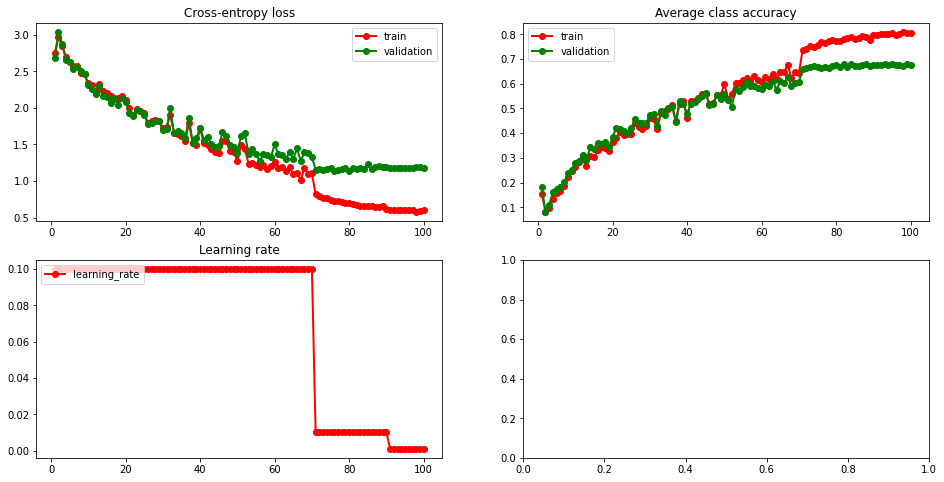

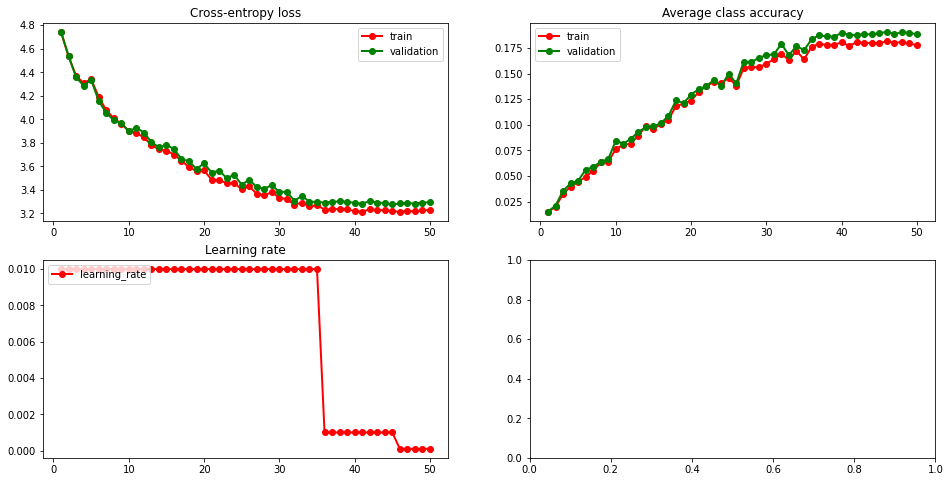

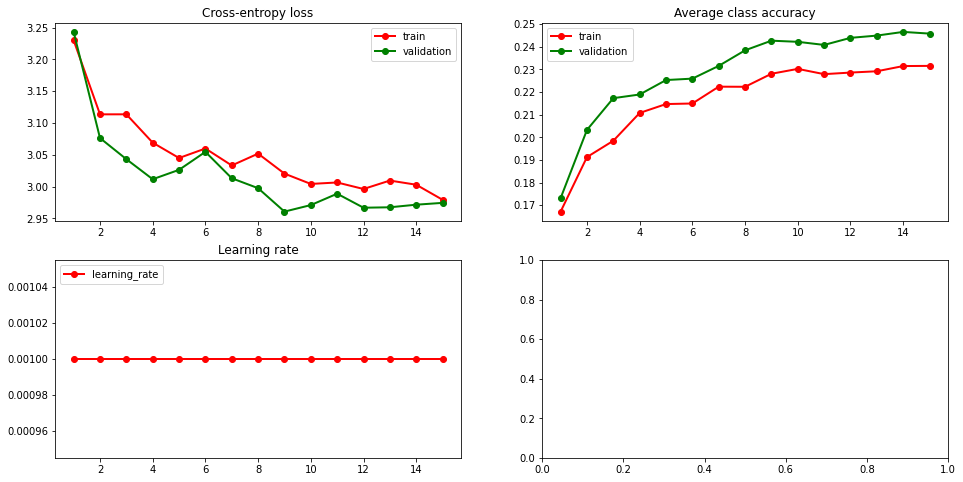

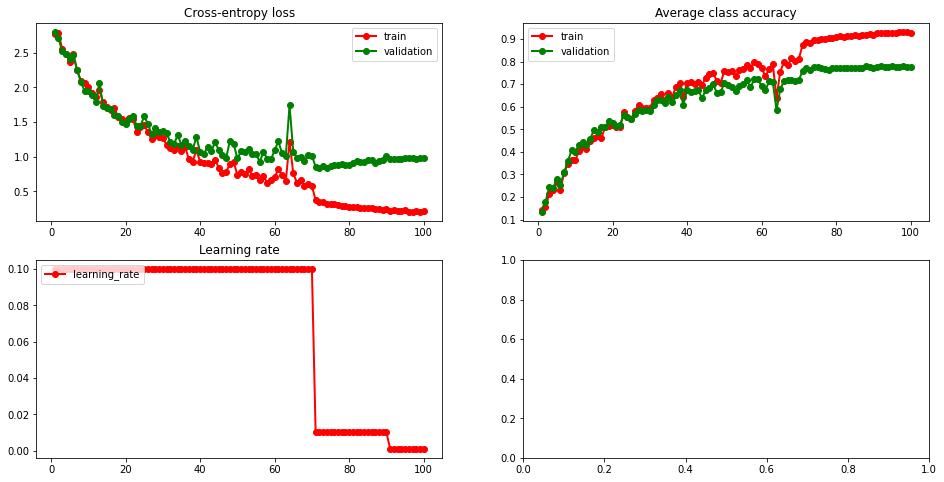

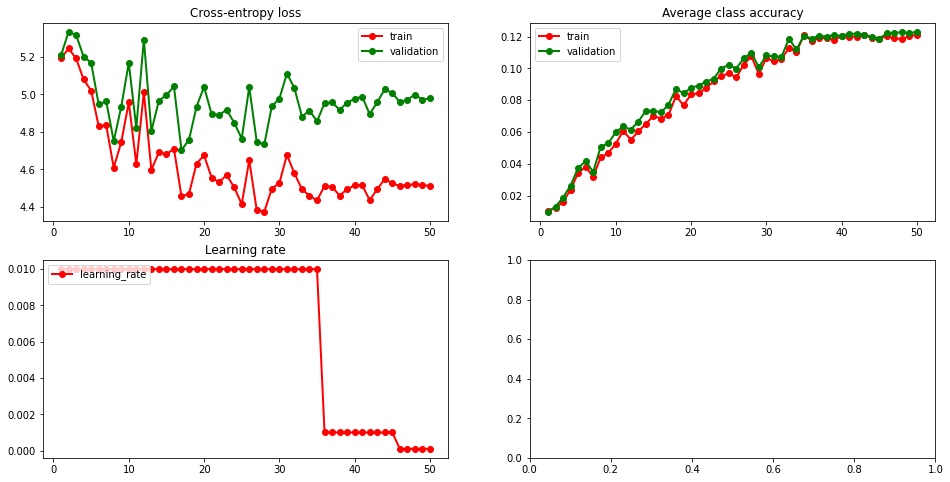

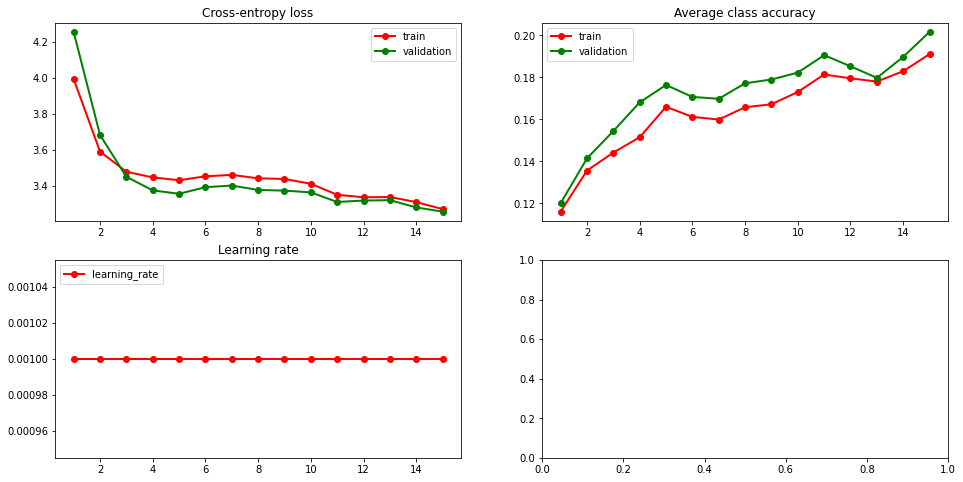

In [ ]:
if __name__=='__main__':
  if os.path.exists(os.path.join(SAVE_DIR, 'runtime_networks/iteration.txt')):
    iterator = 0
    with open(os.path.join(SAVE_DIR, 'runtime_networks/plot_data.txt'), 'rb') as f: 
      plot_data = pickle.load(f)
    with open(os.path.join(SAVE_DIR, 'runtime_networks/iteration.txt'), 'r') as f:
      iterator = int(f.read())

    network = ResidualNetwork(classes_batch_size*(iterator+1)).to(device=device)
    network.load_state_dict(torch.load(PATH))
    network.train()
    for iter in range(iterator+1, int(len(classes)/classes_batch_size)):
      eval_traindataset = torch.utils.data.ConcatDataset(subsetsTrain[0:(iter+1)])
      eval_testdataset = torch.utils.data.ConcatDataset(subsetsTest[0:(iter+1)])
      eval_trainloader = torch.utils.data.DataLoader(eval_traindataset, batch_size=batch_size,
                                            shuffle=True, num_workers=0)
      eval_testloader = torch.utils.data.DataLoader(eval_testdataset, batch_size=batch_size,
                                        shuffle=True, num_workers=0)
      print("Train a new network:")
      print("=================")
      print(classes[classes_batch_size * (iter):classes_batch_size * (iter+1)])
      print("=================")
      newNetwork, val_loss, val_acc = trainNetwork(iter)
      plot_data['batch_train_loss'].append(val_loss)
      plot_data['batch_train_acc'].append(val_acc)
      print("Consolidation stage:")
      print("=================")
      consolidateNetwork, val_loss, val_acc = deepModelConsolidation(network, newNetwork, classes_batch_size * (iter+1), iter, eval_trainloader, eval_testloader)
      plot_data['batch_dmc_loss'].append(val_loss)
      plot_data['batch_dmc_acc'].append(val_acc)
      print("Fine tuning stage:")
      print("=================")
      network, val_loss, val_acc = fineTuning(consolidateNetwork, iter, eval_trainloader, eval_testloader)
      torch.save(network.state_dict(), PATH)
      plot_data['batch_loss'].append(val_loss)
      plot_data['batch_acc'].append(val_acc)
      plot_data['iter'].append(iter)
      torch.save(network.state_dict(), PATH)
      with open(os.path.join(SAVE_DIR, 'runtime_networks/plot_data.txt'), 'wb') as f: 
        pickle.dump(plot_data, f)
      with open(os.path.join(SAVE_DIR, 'runtime_networks/iteration.txt'), 'w') as f:
        f.write(str(iter))
      print("=================")
      print("ITERATION:", iter, "\nAccuracy:", val_acc, "\nLoss:", val_loss)

  else:
    plot_data = {}
    plot_data['batch_loss'] = []
    plot_data['batch_acc'] = []
    plot_data['iter'] = [0]
    plot_data['batch_train_loss'] = []
    plot_data['batch_train_acc'] = []
    plot_data['batch_dmc_loss'] = []
    plot_data['batch_dmc_acc'] = []
    print("Train a new network:")
    print("=================")
    print(classes[0:classes_batch_size])
    print("=================")
    network, val_loss, val_acc = trainNetwork(0)
    plot_data['batch_loss'].append(val_loss)
    plot_data['batch_acc'].append(val_acc)
    torch.save(network.state_dict(), PATH)
    with open(os.path.join(SAVE_DIR, 'runtime_networks/plot_data.txt'), 'wb') as f: 
      pickle.dump(plot_data, f)
    with open(os.path.join(SAVE_DIR, 'runtime_networks/iteration.txt'), 'w') as f:
      f.write(str(0))
    print("=================")
    print("ITERATION:", 0, "\nAccuracy:", val_acc, "\nLoss:", val_loss)
    for iter in range(1, int(len(classes)/classes_batch_size)):
      eval_traindataset = torch.utils.data.ConcatDataset(subsetsTrain[0:(iter+1)])
      eval_testdataset = torch.utils.data.ConcatDataset(subsetsTest[0:(iter+1)])
      eval_trainloader = torch.utils.data.DataLoader(eval_traindataset, batch_size=batch_size,
                                            shuffle=True, num_workers=0)
      eval_testloader = torch.utils.data.DataLoader(eval_testdataset, batch_size=batch_size,
                                        shuffle=True, num_workers=0)
      print("Train a new network:")
      print("=================")
      print(classes[classes_batch_size * (iter):classes_batch_size * (iter+1)])
      print("=================")
      newNetwork, val_loss, val_acc = trainNetwork(iter)
      plot_data['batch_train_loss'].append(val_loss)
      plot_data['batch_train_acc'].append(val_acc)
      print("Consolidation stage:")
      print("=================")
      consolidateNetwork, val_loss, val_acc = deepModelConsolidation(network, newNetwork, classes_batch_size * (iter+1), iter, eval_trainloader, eval_testloader)
      plot_data['batch_dmc_loss'].append(val_loss)
      plot_data['batch_dmc_acc'].append(val_acc)
      print("Fine tuning stage:")
      print("=================")
      network, val_loss, val_acc = fineTuning(consolidateNetwork, iter, eval_trainloader, eval_testloader)
      plot_data['batch_loss'].append(val_loss)
      plot_data['batch_acc'].append(val_acc)
      plot_data['iter'].append(iter)
      torch.save(network.state_dict(), PATH)
      with open(os.path.join(SAVE_DIR, 'runtime_networks/plot_data.txt'), 'wb') as f: 
        pickle.dump(plot_data, f)
      with open(os.path.join(SAVE_DIR, 'runtime_networks/iteration.txt'), 'w') as f:
        f.write(str(iter))
      print("=================")
      print("ITERATION:", iter, "\nAccuracy:", val_acc, "\nLoss:", val_loss)

  with open(os.path.join(SAVE_DIR, "final_eval_data/eval_" + str(K) + "_" + str(classes_batch_size) + ".txt"), 'w') as f:
    f.write("Train accuracy\n")
    f.write(str(plot_data['batch_train_acc']) + "\n")
    f.write("Train loss\n")
    f.write(str(plot_data['batch_train_loss']) + "\n")
    f.write("Consolidation accuracy\n")
    f.write(str(plot_data['batch_dmc_acc']) + "\n")
    f.write("Consolidation loss\n")
    f.write(str(plot_data['batch_dmc_loss']) + "\n")
    f.write("Final accuracy\n")
    f.write(str(plot_data['batch_acc']) + "\n")
    f.write("Final loss\n")
    f.write(str(plot_data['batch_loss']) + "\n")
    f.write(str(plot_data['iter']))

  with open(os.path.join(SAVE_DIR, 'final_eval_data/plot_data.txt'), 'wb') as f: 
    pickle.dump(plot_data, f)

  END = os.path.join(SAVE_DIR, "CIFAR_100/dmc_net_" + str(K) + ".pth")
  torch.save(network.state_dict(), END)


  

  
  

  